In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

### Track analysis

In [ ]:
f1_circuits = [
    ["Albert Park Circuit", "Australia", -37.8497, 144.9689],
    ["Bahrain International Circuit", "Bahrain", 26.0325, 50.5106],
    ["Jeddah Corniche Circuit", "Saudi Arabia", 21.6319, 39.1044],
    ["Shanghai International Circuit", "China", 31.3389, 121.2205],
    ["Miami International Autodrome", "USA", 25.9581, -80.2389],
    ["Baku City Circuit", "Azerbaijan", 40.3725, 49.8533],
    ["Circuit de Monaco", "Monaco", 43.7347, 7.4206],
    ["Circuit de Barcelona-Catalunya", "Spain", 41.5689, 2.2569],
    ["Red Bull Ring", "Austria", 47.2197, 14.7647],
    ["Silverstone Circuit", "UK", 52.0786, -1.0169],
    ["Hungaroring", "Hungary", 47.5830, 19.2506],
    ["Circuit de Spa-Francorchamps", "Belgium", 50.4372, 5.9713],
    ["Circuit Zandvoort", "Netherlands", 52.3888, 4.5431],
    ["Autodromo Nazionale Monza", "Italy", 45.6156, 9.2819],
    ["Marina Bay Street Circuit", "Singapore", 1.2914, 103.8644],
    ["Suzuka Circuit", "Japan", 34.8431, 136.5407],
    ["Losail International Circuit", "Qatar", 25.4886, 51.4536],
    ["Circuit of the Americas", "USA", 30.1328, -97.6411],
    ["Autódromo Hermanos Rodríguez", "Mexico", 19.4042, -99.0907],
    ["Autódromo José Carlos Pace", "Brazil", 23.7036, -46.6997],
    ["Las Vegas Strip Circuit", "USA", 36.1147, -115.1728],
    ["Yas Marina Circuit", "UAE", 24.4672, 54.6031],
    ["Imola Circuit", "Italy", 44.3439, 11.7167]
]

56
          lon        lat     x     y
0 -115.162219  36.109017     0     0
1 -115.160250  36.110295  1769  1421
2 -115.160217  36.110399  1798  1537
3 -115.160308  36.110513  1717  1663
4 -115.160459  36.110517  1581  1668


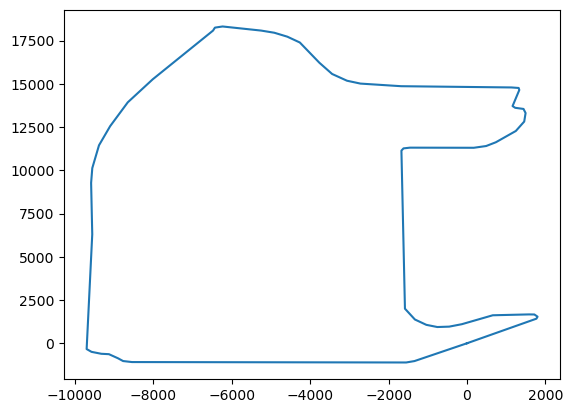

In [10]:
import json

track_name = "Las Vegas"

# Read data from geojson file
file = open("./datasets/f1-circuits.geojson", "rb")
content = file.read()
tracks_data = json.loads(content)["features"]

# Select track coordinates
select_gp = [x["geometry"]["coordinates"] for x in tracks_data if x["properties"]["Location"] == track_name]
track_data = pd.DataFrame(select_gp[0], columns=["lon", "lat"])


def convert_latlon_to_xy(lat, lon, origin_lat=None, origin_lon=None):
    """
    Convert a single GPS coordinate to XY coordinates in 1/10th meters
    
    Args:
        lat (float): Latitude of the point to convert
        lon (float): Longitude of the point to convert
        origin_lat (float, optional): Origin point latitude. If None, uses the input point as origin
        origin_lon (float, optional): Origin point longitude. If None, uses the input point as origin
    
    Returns:
        tuple: (x, y) coordinates in 1/10th meters from origin
    """
    # If no origin provided, return (0,0)
    if origin_lat is None or origin_lon is None:
        return (0, 0)
        
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371000  # Earth radius in meters
        lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
        
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        
        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
        c = 2 * math.asin(math.sqrt(a))
        return R * c

    def get_bearing(lat1, lon1, lat2, lon2):
        lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
        dlon = lon2 - lon1
        
        y = math.sin(dlon) * math.cos(lat2)
        x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dlon)
        return math.atan2(y, x)

    # Calculate distance from origin
    distance = haversine_distance(origin_lat, origin_lon, lat, lon)
    
    # Calculate bearing from origin
    bearing = get_bearing(origin_lat, origin_lon, lat, lon)
    
    # Convert to XY coordinates (multiply by 10 for 1/10th meter precision)
    x = round(distance * math.sin(bearing) * 10)
    y = round(distance * math.cos(bearing) * 10)
    
    return pd.Series([x, y])


# Rotate array to start/finish
# monaco_start = (43.7347, 7.4206)
# distance = np.sqrt((track_data["lat"].values - monaco_start[0])**2 + (track_data["lon"].values - monaco_start[1])**2)
# index = (np.abs(distance)).argmin() + 1

# Convert latlon track coordinates to xy coordinates
track_data[["x", "y"]] = track_data.apply(lambda row: convert_latlon_to_xy(row["lat"], row["lon"], track_data["lat"].values[0], track_data["lon"].values[0]), axis=1)

# track_before = track_data.iloc[:(index)]
# track_after = track_data.iloc[(index):]

# track_data = pd.concat([
#     track_after,
#     track_before
# ]).reset_index(drop=True).drop_duplicates()


print(len(track_data))
print(track_data.head())
plt.plot(track_data["x"].values, track_data["y"].values)

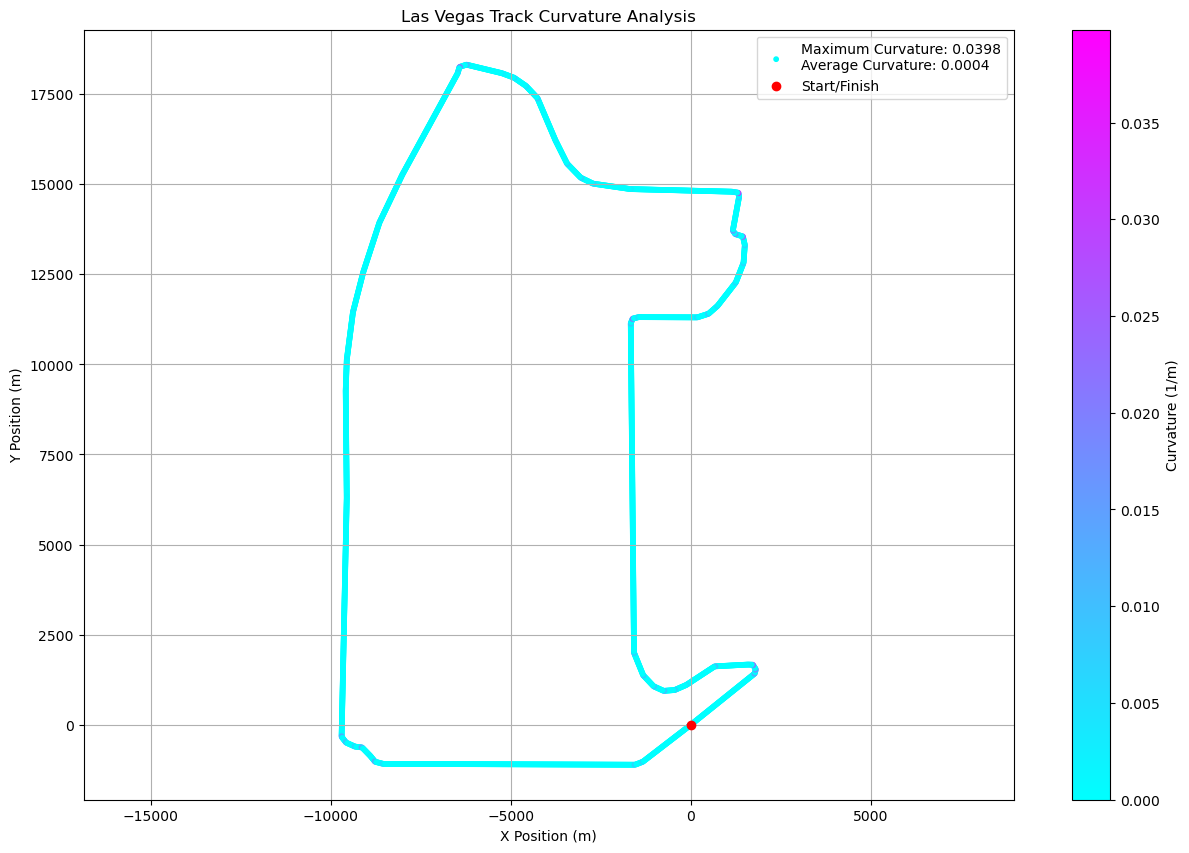

Maximum curvature: 0.0398 m^-1
Average curvature: 0.0004 m^-1
Minimum curvature: 0.0000 m^-1


In [12]:
from scipy.interpolate import splprep, splev

def smooth_track_data(x, y, num_points=1000):

    # Remove duplicate consecutive points
    points = np.column_stack((x, y))
    unique_points = np.vstack([tuple(row) for row in points])
    x, y = unique_points.T
    
    # Fit a B-spline
    tck, u = splprep([x, y], s=0, k=1, per=True)
    
    # Generate points along the smoothed curve
    u_new = np.linspace(0, 1, num_points)
    x_new, y_new = splev(u_new, tck)
    
    return x_new, y_new

def calculate_curvature(x, y):

    # Ensure inputs are numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    # Calculate first derivatives
    dx_dt = np.gradient(x)
    dy_dt = np.gradient(y)
    
    # Calculate second derivatives
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    
    # Calculate curvature using the formula
    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**(3/2)
    
    return curvature

def plot_track_curvature(x, y, curvature):

    plt.figure(figsize=(15, 10))
    
    # Plot track colored by curvature
    points = plt.scatter(x, y, c=curvature, cmap='cool', 
                        s=10, 
                        label=f'Maximum Curvature: {np.max(curvature):.4f}\nAverage Curvature: {np.mean(curvature):.4f}'
            )
    plt.plot(x[0], y[0], 'ro', label="Start/Finish")
    plt.colorbar(points, label='Curvature (1/m)')
    plt.legend()
    plt.title(f'{track_name} Track Curvature Analysis')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.axis('equal')
    plt.grid(True)
    plt.show()


x_smooth, y_smooth = smooth_track_data(track_data["x"].values, track_data["y"].values, 3000)

curvature = calculate_curvature(x_smooth, y_smooth)

plot_track_curvature(x_smooth, y_smooth, curvature)

print(f"Maximum curvature: {np.max(curvature):.4f} m^-1")
print(f"Average curvature: {np.mean(curvature):.4f} m^-1")
print(f"Minimum curvature: {np.min(curvature):.4f} m^-1")


### Telemetry data analysis

In [24]:
circuit_name = "Monaco"
lap_data = pd.read_csv(f"./datasets/lapdata/{circuit_name}_Grand_Prix.csv")
telem_data = pd.read_csv(f"./datasets/telemetry_data/{circuit_name}_time_series.csv")

In [25]:
driver_id = "VER"

In [26]:
driver_laps = lap_data.loc[lap_data["Driver"] == driver_id]
driver_race_time = pd.to_datetime(driver_laps["LapTime"].sum(), unit="s").time()
driver_laps = driver_laps.set_index(pd.to_datetime(driver_laps["LapStartDate"])).drop(["LapStartDate"], axis=1)
print(driver_race_time)
print(driver_laps.head())

02:20:51.964000
                         DriverNumber Driver  LapNumber Compound  TyreLife  \
LapStartDate                                                                 
2024-05-26 13:03:11.069             1    VER        1.0     HARD       1.0   
2024-05-26 13:44:00.122             1    VER        2.0   MEDIUM       1.0   
2024-05-26 13:47:07.789             1    VER        3.0   MEDIUM       2.0   
2024-05-26 13:48:33.533             1    VER        4.0   MEDIUM       3.0   
2024-05-26 13:49:56.808             1    VER        5.0   MEDIUM       4.0   

                         Sector1Time  Sector2Time  Sector3Time   LapTime  \
LapStartDate                                                               
2024-05-26 13:03:11.069          NaN       50.381          NaN  2478.944   
2024-05-26 13:44:00.122       24.134       38.218       95.091       NaN   
2024-05-26 13:47:07.789       24.715       38.860       22.169    85.744   
2024-05-26 13:48:33.533       21.947       38.888       2

In [27]:
print(telem_data.head())
driver_telemetry = telem_data.loc[telem_data["Driver"] == driver_id] \
        [["Date", "RPM", "Speed", "nGear", "Throttle", "X", "Y"]]

driver_telemetry = driver_telemetry \
            .set_index(pd.to_datetime(driver_telemetry["Date"])).drop(["Date"], axis=1)

driver_telemetry.head(n=10)

                      Date    RPM  Speed  nGear  Throttle  Brake  DRS  \
0  2024-05-26 13:03:11.069  10500      0      1        38   True    1   
1  2024-05-26 13:03:11.156  10501      0      1        38   True    1   
2  2024-05-26 13:03:11.230  10464      0      1        38   True    1   
3  2024-05-26 13:03:11.356  10427      0      1        38   True    1   
4  2024-05-26 13:03:11.469   9657      1      1        37   True    1   

                     Time             SessionTime  DriverAhead  \
0         0 days 00:00:00  0 days 00:55:05.680000          NaN   
1  0 days 00:00:00.087000  0 days 00:55:05.767000          NaN   
2  0 days 00:00:00.161000  0 days 00:55:05.841000          NaN   
3  0 days 00:00:00.287000  0 days 00:55:05.967000         23.0   
4  0 days 00:00:00.400000  0 days 00:55:06.080000         23.0   

   DistanceToDriverAhead            X            Y  LapNumber  TrackStatus  \
0               0.159444 -7651.000291 -6789.990523        1.0         1254   
1       

,RPM,Speed,nGear,Throttle,X,Y
Date,,,,,,
2024-05-26 13:03:11.069,10000,0,1,15,-7626.012403,-7092.987813
2024-05-26 13:03:11.156,10010,0,1,15,-7626.019289,-7092.980972
2024-05-26 13:03:11.230,10001,0,1,15,-7626.000000,-7093.000000
2024-05-26 13:03:11.356,9992,0,1,15,-7625.915669,-7093.083193
2024-05-26 13:03:11.469,9012,0,1,15,-7626.000000,-7093.000000
2024-05-26 13:03:11.676,8032,0,1,15,-7626.860261,-7091.795787
2024-05-26 13:03:11.729,7378,3,1,15,-7627.000000,-7091.000000
2024-05-26 13:03:11.949,6725,7,1,15,-7627.000000,-7085.000000
2024-05-26 13:03:11.956,6072,11,1,15,-7627.006023,-7084.740977


In [28]:
################ Merge race data with telemetry data ################
select_lap_data = driver_laps[["LapNumber", "TrackStatus", "Compound", "TyreLife"]]

additional_columns = ["TrackStatus", "Compound"]

def merge_race_data(driver_telemetry: pd.DataFrame, select_lap_data: pd.DataFrame):
    lap_times = select_lap_data.index
    lap_numbers = select_lap_data['LapNumber']

    # Initialize lap column
    result_df = driver_telemetry.copy()
    result_df['LapNumber'] = None

    # Assign lap numbers
    for i in range(len(lap_times)-1):
        current_lap_start = lap_times[i]
        next_lap_start = lap_times[i+1]
        current_lap_number = lap_numbers.iloc[i]
        
        # Assign lap number to all rows between current and next lap start
        mask = (result_df.index >= current_lap_start) & (result_df.index < next_lap_start)
        result_df.loc[mask, 'LapNumber'] = current_lap_number

        for col in additional_columns:
            result_df.loc[mask, col] = select_lap_data[col].iloc[i]

    # Handle last lap
    last_lap_mask = result_df.index >= lap_times[-1]
    result_df.loc[last_lap_mask, 'LapNumber'] = lap_numbers.iloc[-1]

    # Handle additional columns for last lap
    for col in additional_columns:
        result_df.loc[last_lap_mask, col] = select_lap_data[col].iloc[-1]

    driver_telemetry = result_df.copy()

    return driver_telemetry


Text(0.5, 1.0, 'Timeseries data sampling step')

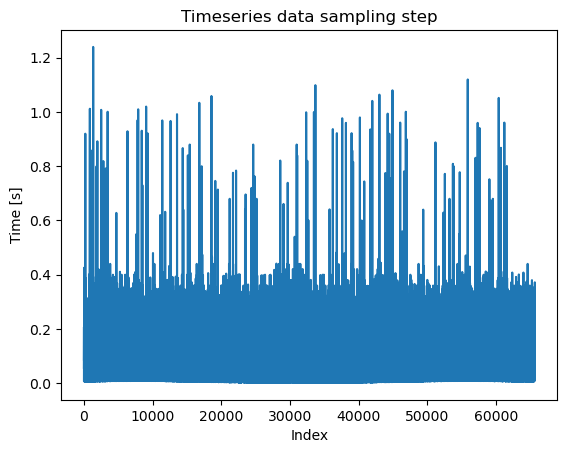

In [29]:
########### Check data sampling step ###########
DT = (driver_telemetry.index[1:] - driver_telemetry.index[:-1]).total_seconds()
plt.plot(np.arange(len(driver_telemetry.index[:-1])), DT)
plt.ylabel("Time [s]")
plt.xlabel("Index")
plt.title("Timeseries data sampling step")

#### Current approach

In [30]:
def resample_and_interpolate_data(driver_telemetry: pd.DataFrame):
    car_data = pd.DataFrame(
        {
            "Speed": driver_telemetry["Speed"].values / 3.6, # convert from km/h to m/s
            "X": driver_telemetry["X"].values,
            "Y": driver_telemetry["Y"].values
        },
        index = driver_telemetry.index
    )


    resampled_telemetry = car_data.resample('500ms').agg({
        'Speed': 'mean',
        'X': 'mean',
        'Y': 'mean'
    }).interpolate(method="linear", limit_direction="forward", axis=0)

    return resampled_telemetry

resampled_telem = resample_and_interpolate_data(driver_telemetry)

merged_telem_lap = merge_race_data(resampled_telem, select_lap_data).dropna()
merged_telem_lap = merged_telem_lap[merged_telem_lap["TrackStatus"] == 1.0]

In [31]:
########### Calculate car acceleration ###########

acceleration = np.gradient(merged_telem_lap["Speed"].values)

merged_telem_lap["Acceleration"] = acceleration

velocity_data = merged_telem_lap[["Speed", "LapNumber"]]

merged_telem_lap['Acceleration'] = merged_telem_lap['Acceleration'].clip(lower=0.0)
positive_acceleration_data = merged_telem_lap#[merged_telem_lap["Acceleration"] > 0.0][["Acceleration", "Speed", "LapNumber", "X", "Y"]]


In [32]:
def calculate_cumulative_lap_distance(X, Y):
    distance = np.sqrt((X[1:] - X[:-1])**2 + (Y[1:] - Y[:-1])**2)
    distance = np.append(distance, np.sqrt((X[0] - X[-1])**2 + (Y[0] - Y[-1])**2))

    cumsum_dist = np.cumsum(distance)

    return (cumsum_dist / (cumsum_dist[-1]))

def resample_lap_data(df: pd.DataFrame, n_samples: int, value_columns: list[str]):

    resampled_laps = []

    # Process each lap
    for lap_num in df["LapNumber"].unique():
        lap_data = df[df["LapNumber"] == lap_num].copy()
        
        # Calculate percentage of lap completion (0 to 1) - using timestamps
        # lap_data['LapProgress'] = (lap_data.index - lap_data.index.min()) / \
        #                          (lap_data.index.max() - lap_data.index.min())

        # Calculate percentage of lap completion (0 to 1) - using distance change
        lap_data['LapProgress'] = calculate_cumulative_lap_distance(lap_data["X"].values / 10, lap_data["Y"].values / 10)

        # Create new evenly spaced points for interpolation
        new_points = np.linspace(0, 1, n_samples)
        
        # Initialize resampled lap with basic columns
        resampled_lap = pd.DataFrame({
            "LapNumber": lap_num,
            'SampleIndex': range(n_samples),
            'LapProgress': new_points
        })
        
        # Interpolate each value column
        for column in value_columns:
            resampled_lap[column] = np.interp(new_points,
                                            lap_data['LapProgress'],
                                            lap_data[column])

        resampled_laps.append(resampled_lap)

    # Combine all resampled laps
    result = pd.concat(resampled_laps, ignore_index=True)
    
    return result

max_lap_samples_count = 3000
resampled_accel_lap_data = resample_lap_data(positive_acceleration_data, max_lap_samples_count, ["Acceleration", "Speed", "X", "Y"])


In [33]:
resampled_accel_lap_data

,LapNumber,SampleIndex,LapProgress,Acceleration,Speed,X,Y
0,3.0,0,0.000000,5.750000,38.833333,-7670.841352,-6472.556674
1,3.0,1,0.000333,5.750000,38.833333,-7670.841352,-6472.556674
2,3.0,2,0.000667,5.750000,38.833333,-7670.841352,-6472.556674
3,3.0,3,0.001000,5.750000,38.833333,-7670.841352,-6472.556674
4,3.0,4,0.001334,5.750000,38.833333,-7670.841352,-6472.556674
...,...,...,...,...,...,...,...
224995,78.0,2995,0.998666,0.054209,73.528504,-7656.907746,-6690.087977
224996,78.0,2996,0.999000,0.040656,73.526008,-7657.174877,-6686.182050
224997,78.0,2997,0.999333,0.027104,73.523511,-7657.442008,-6682.276123
224998,78.0,2998,0.999667,0.013552,73.521015,-7657.709139,-6678.370196


In [34]:
m_car = 798
m_fuel = 110
mu = 0.9

laps = positive_acceleration_data["LapNumber"].unique()
n_laps = len(laps)
m_total = m_car + m_fuel
fuel_consumption = m_fuel / n_laps # Linear fuel consuption by each lap

accel_force_data = []
for lap in laps:
    accel_force_data.append(
        ((
            m_total * 
            resampled_accel_lap_data[resampled_accel_lap_data["LapNumber"] == lap]["Acceleration"].values
        ) / mu).tolist()
    )
    m_fuel -= lap*fuel_consumption
    m_total = m_car + m_fuel
    m_fuel = 110

flattened_accel_force_data = sum(accel_force_data, [])
resampled_accel_lap_data["AccelForce"] = flattened_accel_force_data


      SampleIndex         Mean         Std  Min          Max     Curvature
0               0   153.617920  708.975788  0.0  5801.111111  0.000000e+00
1               1   153.617920  708.975788  0.0  5801.111111  1.534708e-18
2               2   153.617920  708.975788  0.0  5801.111111  0.000000e+00
3               3   153.617920  708.975788  0.0  5801.111111  2.569744e-18
4               4   153.617920  708.975788  0.0  5801.111111  1.035036e-18
...           ...          ...         ...  ...          ...           ...
2995         2995  1160.835292  625.835275  0.0  2405.842002  3.489414e-18
2996         2996  1126.962165  643.184751  0.0  2410.368745  1.969830e-19
2997         2997  1088.799298  657.823016  0.0  2414.895488  3.489414e-18
2998         2998  1040.841410  669.351156  0.0  2284.093500  3.292431e-18
2999         2999   972.906863  686.341228  0.0  2294.847737  0.000000e+00

[3000 rows x 6 columns]


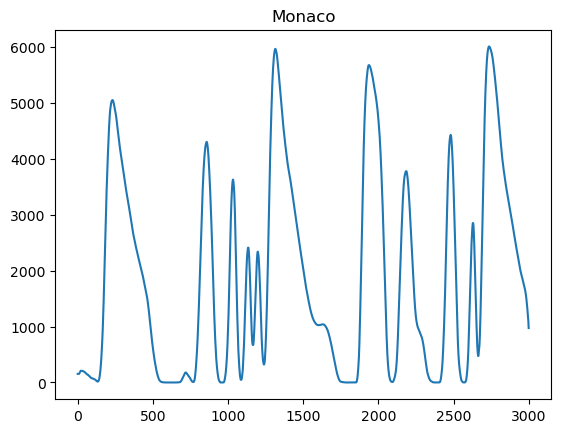

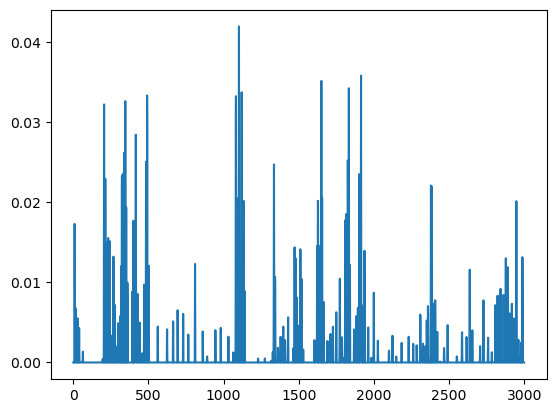

In [35]:
# Calculate stats for each track position for all laps

resampled_accel_lap_data

stats = resampled_accel_lap_data.groupby('SampleIndex').agg({
    "AccelForce": ['mean', 'std', 'min', 'max']
}).reset_index()

stats.columns = ['SampleIndex', 'Mean', 'Std', 'Min', 'Max']

stats["Curvature"] = curvature
print(stats)

plt.plot(np.arange(len(stats)), stats["Mean"])
plt.title(circuit_name)
plt.figure()
plt.plot(np.arange(len(stats)), stats["Curvature"])


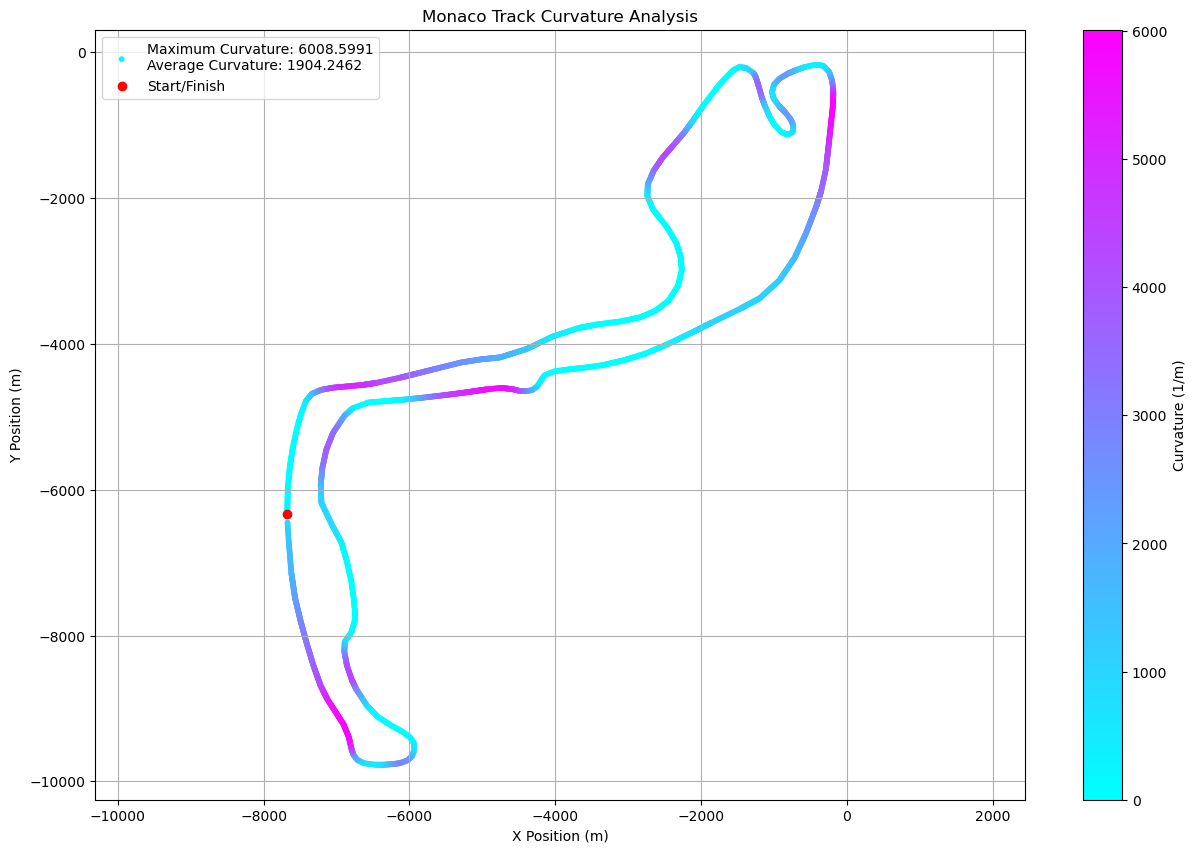

In [38]:
select = resampled_accel_lap_data[resampled_accel_lap_data["LapNumber"] == 12.0]
plot_track_curvature(select["X"].values, select["Y"].values, stats["Mean"].values)
#plot_track_curvature(x_smooth, y_smooth, stats["Mean"].values)
#plot_track_curvature(x_resampled, y_resampled, stats["Mean"].values)

#### Old approach

In [ ]:
driver_telemetry = merge_race_data(driver_telemetry, select_lap_data)
driver_telemetry.head()
select_lap_data.loc[select_lap_data["TrackStatus"] != 1.0]

In [ ]:
car_data = pd.DataFrame(
    {
        "Speed": driver_telemetry["Speed"].values / 3.6, # convert from km/h to m/s
        "LapNumber": driver_telemetry["LapNumber"].values,
        "X": driver_telemetry["X"].values,
        "Y": driver_telemetry["Y"].values
    },
    index = driver_telemetry.index
)

########### Resample and aggregate selected data ###########

downsampled_groups = []
for lap, lap_data in car_data.groupby('LapNumber'):
    lap_downsampled = lap_data.resample('1S').agg({
        'Speed': 'mean',
        'LapNumber': 'first',
        'X': 'first',
        'Y': 'first'
    })

    downsampled_groups.append(lap_downsampled)

resampled_car_data = pd.concat(downsampled_groups).sort_index()

In [152]:
########### Calculate car acceleration ###########

acceleration = np.abs(np.gradient(resampled_car_data["Speed"].values))

resampled_car_data["Acceleration"] = acceleration

In [ ]:
########### Calculate and display car mean velocity and acceleration by lap ###########

compound_colors = {
    'SOFT': 'red',
    'MEDIUM': 'gold',
    'HARD': 'gray',
    'INTERMEDIATE': 'green',
    'WET': 'blue'
}


print(select_lap_data.head())


car_data_by_lap = resampled_car_data.groupby("LapNumber").mean()
print(car_data_by_lap.head())

plt.figure()

lap_compounds = select_lap_data["Compound"].values
laps_tyre_life = select_lap_data["TyreLife"].values
track_statuses = select_lap_data["TrackStatus"].values
current_compound = lap_compounds[0]
start_event_region = -1
end_event_region = -1

# Plot velocity
plt.plot(np.arange(1, len(car_data_by_lap["Speed"])+1), car_data_by_lap["Speed"].values * 3.6, c='blue')

# Plot tire changes
plt.axvline(x=select_lap_data["LapNumber"].values[0], color=compound_colors[current_compound], linestyle='--', label=f"{current_compound}")
for i in range(len(lap_compounds)):
    if i < len(lap_compounds) - 1 and laps_tyre_life[i] >= laps_tyre_life[i + 1]:
        current_compound = lap_compounds[i + 1]
        plt.axvline(x=select_lap_data["LapNumber"].values[i+1], color=compound_colors[current_compound], linestyle='--', label=f"{current_compound}")

    if start_event_region == -1 and track_statuses[i] != 1.0:
        start_event_region = i
    elif track_statuses[i] == 1.0 and track_statuses[i-1] != 1.0:
        end_event_region = i
        # Mark area between laps where any track event occurs (e.g. yellow or red flag, safety car...)
        plt.fill_between(np.arange(start=start_event_region+1, stop=end_event_region+1), car_data_by_lap["Speed"].values[start_event_region:end_event_region] * 3.6, alpha=0.5, color='lightcoral', label="Track Event")
        start_event_region = -1
        end_event_region = -1


plt.xlabel("Lap Number")
plt.ylabel("Velocity [km/h]")
plt.title(f"{driver_id} velocity by lap ({circuit_name})")
plt.grid()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.figure()
plt.plot(np.arange(1, len(car_data_by_lap["Acceleration"])+1), car_data_by_lap["Acceleration"].values, c='blue')
plt.xlabel("LapNumber")
plt.ylabel(r"Acceleration [$m/s^2$]")
plt.title(f"{driver_id} acceleration by lap ({circuit_name})")
plt.grid()

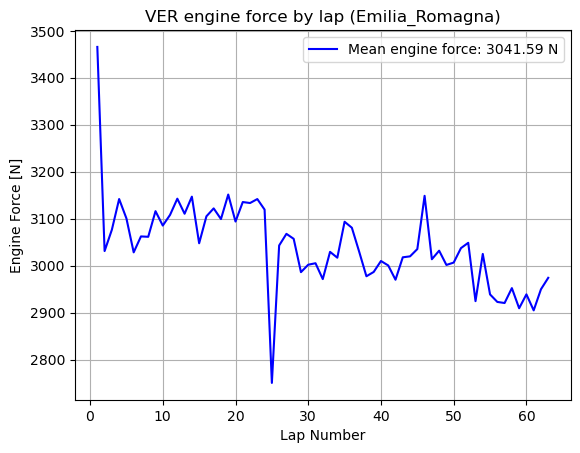

In [156]:
########### Calculate and display mean car engine force by lap ###########

m_car = 798
m_fuel = 110
mu = 1.7

n_laps = len(car_data_by_lap)
m_total = m_car + m_fuel
fuel_consumption = m_fuel / n_laps # Linear fuel consuption by each lap

engine_force_data = []
for accel in car_data_by_lap["Acceleration"].values:
    engine_force_data.append((m_total * accel) / mu)
    m_fuel -= fuel_consumption
    m_total = m_car + m_fuel

car_data_by_lap["EngineForce"] = engine_force_data

plt.figure()
plt.plot(np.arange(1, len(car_data_by_lap["EngineForce"])+1), car_data_by_lap["EngineForce"].values, label=f"Mean engine force: {np.mean(engine_force_data):.2f} N", c='blue')
plt.xlabel("Lap Number")
plt.ylabel("Engine Force [N]")
plt.title(f"{driver_id} engine force by lap ({circuit_name})")
plt.legend()
plt.grid()
